### Random Forest Crocodile Matcher (RF_croc_matcher.ipynb)

**Model:** Random Forest Classifier  
**Dataset:** crocodile_dataset.csv  

This notebook builds a Random Forest model to classify the **Conservation Status** of crocodiles using the provided dataset.  

It includes:
- Import libraries  
- Load & inspect data  
- Exploratory Data Analysis (EDA)  
- Data cleaning & preprocessing  
- Define X and y  
- Train/test split  
- Build preprocessing + RF pipeline  
- Hyperparameter tuning (GridSearchCV)  
- Model evaluation  
- Feature importance analysis

In [1]:
# Core data tools
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model and training utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score, log_loss, classification_report, confusion_matrix
)

# Model
from sklearn.ensemble import RandomForestClassifier

#### 1. Dataset Overview & Missing Values

In [2]:
# Load dataset
croc_df = pd.read_csv("crocodile_dataset.csv")

# Preview first rows
display(croc_df.head())

# Print dataset shape
print("Shape:", croc_df.shape)

# Display dataset information
print("\nDataset Info:")
croc_df.info()

# Display missing values in table format
print("\nMissing values:")
print(croc_df.isnull().sum())

,Observation ID,Common Name,Scientific Name,Family,Genus,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status,Observer Name,Notes
0,1,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern,Allison Hill,Cause bill scientist nation opportunity.
1,2,American Crocodile,Crocodylus acutus,Crocodylidae,Crocodylus,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable,Brandon Hall,Ago current practice nation determine operatio...
2,3,Orinoco Crocodile,Crocodylus intermedius,Crocodylidae,Crocodylus,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered,Melissa Peterson,Democratic shake bill here grow gas enough ana...
3,4,Morelet's Crocodile,Crocodylus moreletii,Crocodylidae,Crocodylus,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern,Edward Fuller,Officer relate animal direction eye bag do.
4,5,Mugger Crocodile (Marsh Crocodile),Crocodylus palustris,Crocodylidae,Crocodylus,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable,Donald Reid,Class great prove reduce raise author play mov...


Shape: (1000, 15)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Observation ID        1000 non-null   int64  
 1   Common Name           1000 non-null   object 
 2   Scientific Name       1000 non-null   object 
 3   Family                1000 non-null   object 
 4   Genus                 1000 non-null   object 
 5   Observed Length (m)   1000 non-null   float64
 6   Observed Weight (kg)  1000 non-null   float64
 7   Age Class             1000 non-null   object 
 8   Sex                   1000 non-null   object 
 9   Date of Observation   1000 non-null   object 
 10  Country/Region        1000 non-null   object 
 11  Habitat Type          1000 non-null   object 
 12  Conservation Status   1000 non-null   object 
 13  Observer Name         1000 non-null   object 
 14  Notes                 1000 non-null   ob

#### 2. Target Distribution & Correlation

Conservation Status counts:


Conservation Status
Least Concern            384
Critically Endangered    275
Vulnerable               170
Data Deficient           115
Endangered                56
Name: count, dtype: int64

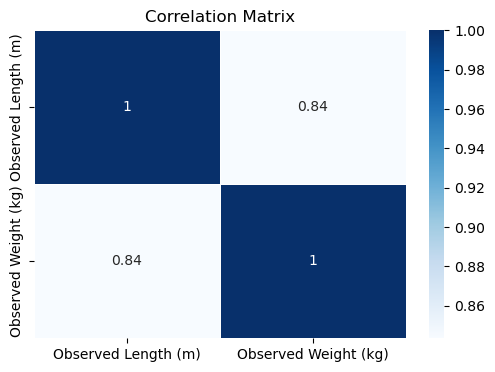

In [3]:
# Show class distribution of the target variable
print("Conservation Status counts:")
display(croc_df["Conservation Status"].value_counts())

# Correlation between numeric features
plt.figure(figsize=(6,4))
sns.heatmap(
    croc_df[["Observed Length (m)", "Observed Weight (kg)"]].corr(),
    annot=True,
    cmap="Blues",
    linewidths=0.5,
    linecolor="white"
)
plt.title("Correlation Matrix")
plt.show()

#### 3. Data Cleaning

In [4]:
# Remove the disputed species row
croc_df = croc_df[croc_df["Common Name"] != "Borneo Crocodile (disputed)"]

# Columns that reveal species or are irrelevant
drop_cols = [
    "Observation ID",     # random ID, no predictive value
    "Observer Name",      # irrelevant to conservation status
    "Notes",              # unstructured text not used in project
    "Scientific Name",    # reveals species
    "Common Name",        # reveals species
    "Family",             # related to species identity
    "Genus"               # related to species identity
]

# Drop unwanted columns
clean_df = croc_df.drop(columns=drop_cols)

clean_df.head()

,Observed Length (m),Observed Weight (kg),Age Class,Sex,Date of Observation,Country/Region,Habitat Type,Conservation Status
0,1.90,62.0,Adult,Male,31-03-2018,Belize,Swamps,Least Concern
1,4.09,334.5,Adult,Male,28-01-2015,Venezuela,Mangroves,Vulnerable
2,1.08,118.2,Juvenile,Unknown,07-12-2010,Venezuela,Flooded Savannas,Critically Endangered
3,2.42,90.4,Adult,Male,01-11-2019,Mexico,Rivers,Least Concern
4,3.75,269.4,Adult,Unknown,15-07-2019,India,Rivers,Vulnerable


#### 4. Process Date & Define Features/Target

In [5]:
# Convert string date to datetime object
clean_df["Date"] = pd.to_datetime(clean_df["Date of Observation"], format="%d-%m-%Y")

# Extract year only (day/month unnecessary for our prediction task)
clean_df["Year"] = clean_df["Date"].dt.year

# Remove raw date columns
clean_df = clean_df.drop(columns=["Date", "Date of Observation"])

# Define target (y) and features (X)
target = "Conservation Status"
y = clean_df[target]
X = clean_df.drop(columns=[target])

clean_df.head()

,Observed Length (m),Observed Weight (kg),Age Class,Sex,Country/Region,Habitat Type,Conservation Status,Year
0,1.90,62.0,Adult,Male,Belize,Swamps,Least Concern,2018
1,4.09,334.5,Adult,Male,Venezuela,Mangroves,Vulnerable,2015
2,1.08,118.2,Juvenile,Unknown,Venezuela,Flooded Savannas,Critically Endangered,2010
3,2.42,90.4,Adult,Male,Mexico,Rivers,Least Concern,2019
4,3.75,269.4,Adult,Unknown,India,Rivers,Vulnerable,2019


#### 5. Train / Test Split & Preprocessing

In [6]:
# Stratified split preserves class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# Identify numeric and categorical columns for preprocessing
num_cols = ["Observed Length (m)", "Observed Weight (kg)", "Year"]
cat_cols = ["Age Class", "Sex", "Country/Region", "Habitat Type"]

# ColumnTransformer applies different preprocessing to numeric vs categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),         # leave numerics unchanged
        ("cat", OneHotEncoder(handle_unknown="ignore"),   # convert categories to binary vectors
         cat_cols)
    ]
)

#### 6. Random Forest Pipeline & Tuning Grid

In [7]:
# Create the pipeline; preprocess first, then apply Random Forest
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

# Hyperparameter search space for GridSearchCV
param_grid = {
    "model__n_estimators": [100, 200, 300],   # number of trees
    "model__max_depth": [None, 5, 10, 20],    # tree depth
    "model__min_samples_split": [2, 5, 10],   # internal node split threshold
    "model__min_samples_leaf": [1, 2, 4]      # minimum leaf size
}

#### 7. Hyperparameter Tuning with GridSearchCV

In [8]:
# Setup grid search with log-loss scoring and 5-fold cross-validation
rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_log_loss",
    n_jobs=-1,
    verbose=1  # prints progress
)

# Fit on training data
rf_grid.fit(X_train, y_train)

# Show the best discovered parameters
rf_grid.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'model__max_depth': None,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 100}

#### 8. Model Evaluation

In [9]:
# Retrieve best model from grid search
best_rf = rf_grid.best_estimator_

# Predict classes and prediction probabilities
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)

# Accuracy and log-loss metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_proba))

# Detailed per-class performance
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9893048128342246
Log Loss: 0.1790084939879119

Classification Report:

                       precision    recall  f1-score   support

Critically Endangered       1.00      1.00      1.00        55
       Data Deficient       1.00      1.00      1.00        10
           Endangered       1.00      1.00      1.00        11
        Least Concern       0.99      0.99      0.99        77
           Vulnerable       0.97      0.97      0.97        34

             accuracy                           0.99       187
            macro avg       0.99      0.99      0.99       187
         weighted avg       0.99      0.99      0.99       187



#### 9. Confusion Matrix

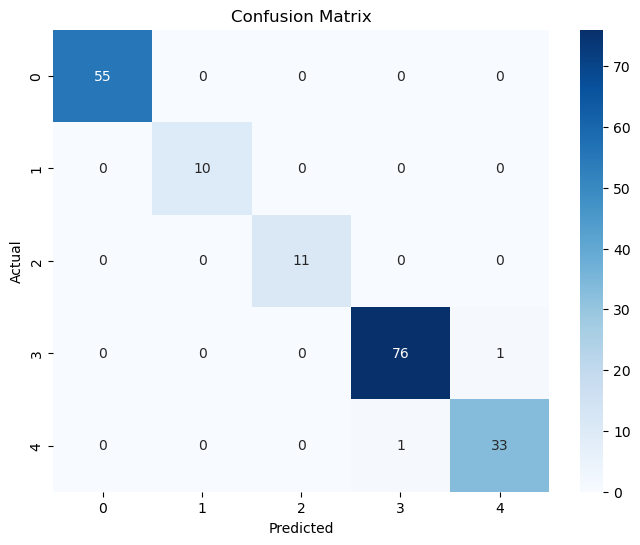

In [10]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot heatmap for easier interpretation
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### 10. Feature Importance Analysis

Top 10 Important Features:

Observed Weight (kg) : 0.10912211620976839
Observed Length (m) : 0.0616747459640906
Country/Region_Papua New Guinea : 0.05129017873488163
Country/Region_Philippines : 0.041164514790933894
Country/Region_Cuba : 0.03666669929897952
Habitat Type_Forest Rivers : 0.030934335118205553
Country/Region_Congo (DRC) : 0.03079719674061042
Country/Region_Congo Basin Countries : 0.030420164323059013
Country/Region_Australia : 0.03014227428860224
Habitat Type_Shaded Forest Rivers : 0.025988396699620057


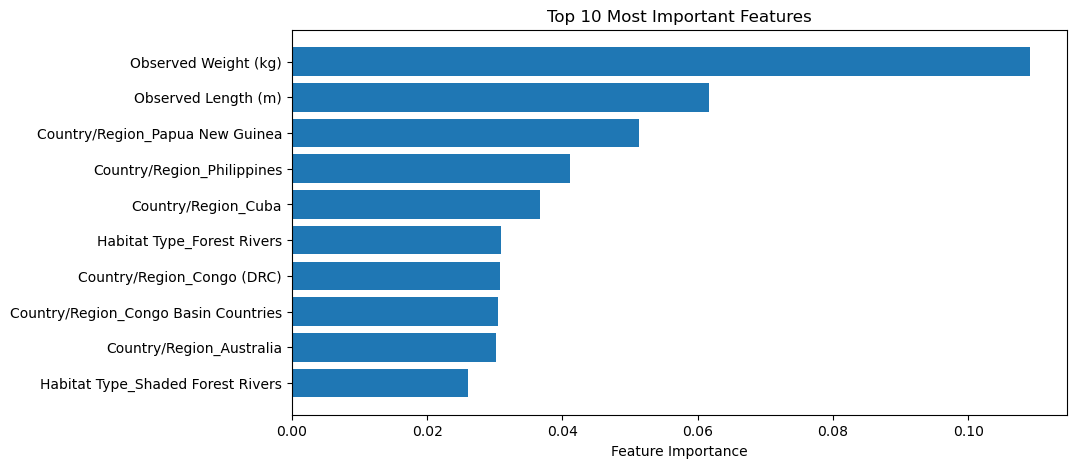

In [11]:
# Extract trained RF model and fitted one-hot encoder
rf_clf = best_rf.named_steps["model"]
ohe = best_rf.named_steps["preprocessor"].named_transformers_["cat"]

# Get names of encoded categorical features
cat_features = ohe.get_feature_names_out(cat_cols)

# Combine numeric + encoded categorical names
all_features = num_cols + list(cat_features)

# Extract feature importance scores from Random Forest
importances = rf_clf.feature_importances_

# Print top 10 most important features
indices = np.argsort(importances)[::-1][:10]

print("Top 10 Important Features:\n")
for idx in indices:
    print(all_features[idx], ":", importances[idx])

# Plot top 10 feature importances
sorted_idx = indices

plt.figure(figsize=(10,5))
plt.barh([all_features[i] for i in sorted_idx], importances[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Top 10 Most Important Features")
plt.gca().invert_yaxis()   # highest at top
plt.show()

#### 11. Summary
In this project, we trained a Random Forest classifier to predict the conservation status of crocodiles using ecological, biological, and geographic features. After performing hyperparameter tuning with GridSearchCV and evaluating the best model on the test set, we obtained strong classification performance measured through accuracy, log-loss, and class-level precision/recall.

**Key Factors Influencing Predictions**

The feature importance analysis revealed meaningful ecological insights:

- **Observed Weight (kg)** and **Observed Length (m)** were the top predictors.  
  This indicates that body size has a substantial influence on conservation risk. Larger or smaller species tend to have distinct vulnerability patterns, which aligns with real-world biological expectations.

- **Country/Region** variables (e.g., Papua New Guinea, Philippines, Cuba, etc) were also highly influential.  
  This makes sense because many crocodile species are geographically restricted, and their conservation statuses vary significantly by location. Some countries host critically endangered species, while others host stable populations.

- **Habitat Type** (e.g., Forest Rivers, Shaded Forest Rivers) appeared within the top 10 features.  
  This shows that environmental context - such as river shading, forest density, and habitat protection levels - plays an important role in determining species risk and survival patterns.

Overall, the model’s behaviour aligns well with ecological theory: **body size, geographic region, and habitat features are naturally strong indicators of conservation status.** The Random Forest model did not rely on leaked species identifiers, which were intentionally removed, confirming that the predictions are based on meaningful traits.


#### 12. Conclusion
The Random Forest model provided:
- Solid predictive performance  
- Clear interpretability through feature importance  
- Ecologically plausible explanations of conservation risk  

These results support the usefulness of Random Forests for multi-class ecological classification and offer a reliable comparison point against the other models in our group.